In [1]:
import boto3
import json
from pinecone import Pinecone
from langchain_core.messages.utils import get_buffer_string
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langchain_core.tools import StructuredTool

class RetrieverInput(BaseModel):
    """ 
    Input model for the retriever tool.
    """
    query: str = Field(..., description="The query text to retrieve documents for.")
    policy_number: str = Field(..., description="The policy number to filter documents by.")
    
class HybridRetriever:
    """ 
    Hybrid Retriever using Bedrock for dense embeddings and pinecone self hosted 
    embedding models for sparse embeddings.
    """
    def __init__(self,pinecone_api_key,index_name) -> None:
        """ 
        Initialize pinecone client and aws services
        """
        try:
            self.bedrock = boto3.client(service_name="bedrock-runtime")
            self.pc = Pinecone(api_key=pinecone_api_key)
            index_response = self.pc.describe_index(name=index_name)
            dns_host = index_response["host"]
            self.index = self.pc.Index(host=dns_host)
            self.s3_client = boto3.client("s3")
        except Exception as e:
            print(f"Error occured in Initialization : {e}")
        

    def generate_dense_embeddings(self,text,model_id="amazon.titan-embed-text-v2:0"):
        """ 
        Generate dense vectors of the document text using aws bedrock 

        Args:
            text (str): text which need to be transformed into dense vectors
            bedrock (aws object): bedrock client for model access
            model_id (str): name of bedrock model
        Returns:
            embedding (List[int]): Dense vector for text data
        """
        try:
            body = json.dumps({
                    "inputText": text,
                    "dimensions": 256,
                    "normalize": True
                })
            response = self.bedrock.invoke_model(
                body=body,
                modelId=model_id,
                accept="application/json",
                contentType="application/json"
            )
            response_body=json.loads(response.get("body").read())
            response=response_body["embedding"]
            return response
        except Exception as e:
            print(f"Error occured in generating dense embeddings {e}")

    def generate_sparse_embeddings(self,text_chunk: str):
        """ 
        Generate sparse embeddings using pinecone hosted embedding models 
        Args:
            pc (Pinecone object): Pinecone client object
            text_chunks (str): Text chunk to be embedded.

        Returns:
            EmbeddingsList: A list of sparse embeddings data 

        """
        try:
            sparse_embeddings = self.pc.inference.embed(
                model="pinecone-sparse-english-v0",
                inputs=[text_chunk],
                parameters={"input_type": "passage", "truncate": "END"}

            )
            return sparse_embeddings
        except Exception as e:
            print(f"Error occured in generating sparse embeddings {e}")

    #@tool(description="Retrieve relevant documents based on query and policy number",args_schema=RetrieverInput)
    def retrieve_documents(self,query:str,policy_number: str):
        """ 
        Perform hybrid retrieval with metadata filtering
        """
        #query_text = get_buffer_string(query)
        dense_vector = self.generate_dense_embeddings(query)
        #print(dense_vector)
        print("Dense embeddings are completed")
        sparse_vector = self.generate_sparse_embeddings(query)
        #print(sparse_vector)
        print("Sparse Embeddings are completed")
        #print(policy_number)

        #Define metadata filter
        filter_query = {"policy_number":policy_number} if policy_number else {}
        search_results = self.index.query(
            namespace="policy-documents",
            vector = dense_vector,
            sparse = sparse_vector,
            top_k = 3,
            alpha = 0.5,
            filter = filter_query,
            include_metadata=True,
            include_values=False,
        )

        #print(search_results)
        print("Search results are completed")
        return search_results["matches"]
    
    def get_tools(self):
        """ 
        Get the tools for hybrid retriever
        """
        return [StructuredTool.from_function(
            name="hybrid_retriever",
            func=self.retrieve_documents,
            description="""Use this tool only when query is related to policy documents.
                 Do not use for general queries even though if policy number is provided.""",
            args_schema=RetrieverInput
        )]


In [2]:
pip install langchain_openai

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from typing import TypedDict, Annotated,List, Dict, Literal
from pydantic import BaseModel, Field
import operator
import datetime
import uuid
import ast
from IPython.display import Image, display
import boto3
import json
from langchain.prompts import PromptTemplate
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage,AIMessage, RemoveMessage
#from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langchain.tools import Tool
from pinecone import Pinecone
#from src.retriever.retriever import HybridRetriever
from dotenv import load_dotenv
load_dotenv()
from functools import partial
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

#### ChatGroq LLM

In [4]:
groq_api_key=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-4o")
#llm = ChatGroq(groq_api_key=groq_api_key,model_name="Llama3-8b-8192")

#### Document Grader

In [5]:
# define a data class
class GradeDocuments(BaseModel):
    """ 
    Grade the retrieved documents based on their relevance to the query.
    """
    binary_score: str = Field(
        description="Document is relevant to the question, 'yes' or 'no'"
    )
# Prompt for the grader
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

structured_llm_retrieval_grader = llm.with_structured_output(GradeDocuments)
retrieval_grader = grade_prompt | structured_llm_retrieval_grader


#### RAG Chain

In [6]:
template = """"
You are a helpful assistant that answers questions based on the following context
Context: {context}
Question: {question}
Answer:

"""
prompt = ChatPromptTemplate.from_template(template)
rag_chain = prompt | llm 

#### Hallucination Grader

In [7]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )
structured_llm_hallucination_grader = llm.with_structured_output(GradeHallucinations)
# prompt for the grader
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_hallucination_grader

#### Answer Grader

In [8]:
# define a data class
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )
structured_llm_answer_grader = llm.with_structured_output(GradeAnswer)

# prompt for the grader
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_answer_grader

#### Input prompt

In [9]:
# prompt for the input node
system = """You are an P&C insurance assistant for question-answering tasks. \n
            You will be provided with a user question and a policy number.\n
            If the question is related to the insurance policy, Make a tool call to the retriever tool to retrieve relevant documents.\n
            If the question is general and not related to any insurance policy documents, you will respond directly to the user 
            irrespective of the policy number provided."""
input_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n Policy Number: {policy_number}"),
    ]
)

#### Rewrite prompt

In [10]:
# prompt for the input node
system = """You are an AI assistant tasked with reformulating user queries to improve retrieval in a RAG system. 
Given the original query, rewrite it to be more specific, detailed, and likely to retrieve relevant information.
Look at the input and try to reason about the underlying semantic intent / meaning.
"""
rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question}"),
    ]
)
rewrite_grader = rewrite_prompt | llm

In [11]:
class State(MessagesState):
    policy_number : str
    filtered_docs : List[str]
    summary : str


class Graph():
    def __init__(self) -> None:

        pinecone_api_key = os.getenv("PINECONE_API_KEY")
        index_name = "insurance-virtual-agent-hybrid"

        self.retriever = HybridRetriever(pinecone_api_key,index_name)
        self.tools = self.retriever.get_tools()
        self.llm_with_tools = llm.bind_tools(self.tools)

    def summarize_conversation(self,State):
        """
        summarize the converstations 
        """
        print("Inside Summarization")
        # First, we get any existing summary
        summary = State.get("summary", "")

        #create summarization prompt
        if summary:
            #A summary already exists
            summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
            )
        else:
            summary_message = "Create a summary of the conversation above:"

        # Add prompt to our history
        conversation_messages = [message for message in State["messages"] if message.type in ("human","system")
                                    or (message.type == "ai" and not message.tool_calls)]

        messages = conversation_messages + [HumanMessage(content=summary_message)]
        response = llm.invoke(messages)

        # Delete all but keep the one most recent messages
        delete_messages = [RemoveMessage(id=m.id) for m in conversation_messages[:-1]]

        return {"summary": response.content, "messages": delete_messages}

    def should_continue(self,State) -> Literal["summarize_conversation","generate_toolcall_or_respond"]:
        """Return the next node to execute."""
    
        messages = State["messages"]

        conversation_messages = [message for message in State["messages"] if message.type in ("human","system")
                                    or (message.type == "ai" and not message.tool_calls)]
        
        # If there are more than six messages, then we summarize the conversation
        if len(conversation_messages) > 6:
            return "summarize_conversation"
        
        # Otherwise we can skip summarization
        return "generate_toolcall_or_respond"

    #node 1 
    def generate_toolcall_or_respond(self,State):
        """ 
        Generate tool call for the retriever tool based on the user query and policy number.
        or respond to the user directly if the query is not related to any policy.
        """
        print("Inside generate_toolcall_or_respond")
        try:
            # Get summary if it exists
            summary = State.get("summary", "")

            conversation_messages = [message for message in State["messages"] if message.type in ("human","system")
                                    or (message.type == "ai" and not message.tool_calls)]
            if summary:
                # Add summary to system message
                system_message = f"Summary of conversation earlier: {summary}"

                # Append summary to any newer messages
                messages = [SystemMessage(content=system_message)] + conversation_messages
            else:
                messages = conversation_messages

            prompt = input_prompt.invoke({
                "question": messages,
                "policy_number": State["policy_number"]
            })
            response = self.llm_with_tools.invoke(prompt)
            
            return {"messages": [response]}

        except Exception as e:
            print(f"Error in generate_toolcall_or_respond: {e}")
            return {"messages": [AIMessage(content="I'm sorry, I couldn't process your request.")]}

    

    #node 2 -- filter the retrieved documents based on their relevance to the query
    def grade_documents(self,State): 
        """ 
        filter the retrieved documents based on their relevance to the query 
        
        """
        print("Inside grade_documents")
        try:
            # Get summary if it exists
            summary = State.get("summary", "")

            # Get the converstation messages
            conversation_messages = [message for message in State["messages"] if message.type in ("human","system")
                                    or (message.type == "ai" and not message.tool_calls)]
            
            if summary:
                # Add summary to system message
                system_message = f"Summary of conversation earlier: {summary}"

                # Append summary to any newer messages
                messages = [SystemMessage(content=system_message)] + conversation_messages
            else:
                messages = conversation_messages

            # Get the retrieved documents from the last tool message
            for m in State['messages']:
                m.pretty_print()
            print("Message printing is completed")
            recent_tool_messages = []
            for msg in reversed(State["messages"]):
                if msg.type == "tool":
                    recent_tool_messages.append(msg)
                else:
                    break
            tool_messages = recent_tool_messages[::-1]
            # convert from string "[]" into [] (list)
            docs_list = ast.literal_eval(tool_messages[0].content)
            print(f"document list : \n {len(docs_list)}")
            relevant_docs = []
            for doc in docs_list:
                score = retrieval_grader.invoke({"question": messages, "document": doc["metadata"]["text"]})
                #print(f"Document: \n {doc['metadata']['text']}")
                grade = score.binary_score
                if grade not in ["yes", "no"]:
                    raise ValueError(f"Invalid score received: {grade}. Expected 'yes' or 'no'.")
                if grade == "yes":
                    relevant_docs.append(doc['metadata']['text'])
                    print(f" Retrieved Document : \n {doc['metadata']['text']} ")

            if relevant_docs:
                print("Going into filter documents")
                return {"filtered_docs":relevant_docs}
            else:
                print("No relevant documents found.")
                return {"filtered_docs": []}
        except Exception as e:
            print(f"Error in grade_documents: {e}")
            return {"filtered_docs": []}
    
    def decide_to_generate(self,State) -> Literal["generate_answer", "no_relevant_documents"]:
        """ 
        Decide which node to execute next based on the retrieved documents.
        If no documents are retrieved, respond directly to the user.
        """
        print("Inside decide_to_generate")
        if not State["filtered_docs"]:
           # return "rewrite_query"
             return "generate_answer"
        else:
            return "generate_answer"

    #node 3 -- generate llm response for the query
    def generate_answer(self,State):
        """ 
        Generate the response based on retrieved documents and query for that given
        policy
        """
        # Get summary if it exists
        summary = State.get("summary", "")

        print("Inside generate_answer")
        context = "/n/n".join(doc for doc in State["filtered_docs"])

        # Get the converstation messages
        conversation_messages = [message for message in State["messages"] if message.type in ("human","system")
                                 or (message.type == "ai" and not message.tool_calls)]
        
        if summary:
            # Add summary to system message
            system_message = f"Summary of conversation earlier: {summary}"

            # Append summary to any newer messages
            messages = [SystemMessage(content=system_message)] + conversation_messages
        else:
            messages = conversation_messages

        response = rag_chain.invoke({
            "context": context,
            "question": messages
        })
        return {"messages":[response]}
    
    def rewrite_query(self,State):
        """ 
        Rewrite the query if no relevant documents are found.
        
        """
        print("Inside rewrite query")
        for message in reversed(State["messages"]):
            if message.type == "human":
                question = message.content
                print(f"User original question before rewrite: {question}")
                break
        response = rewrite_grader.invoke({
            "question": question
        })
        rewritten_query = response.content
        print(f"Rewritten query: {rewritten_query}")
    
        return {"messages": [{"role": "human", "content": rewritten_query}]}
    
    def decide_to_regenerate(self,State) -> Literal["useful", "not supported"]:
        """ 
        Decide whether to regenerate the answer based on hallucination and answer grading.
        If the answer is not grounded in the retrieved documents, it is considered "not supported".
        """
        print("Inside decide_to_regenerate")
        # Get summary if it exists
        summary = State.get("summary", "")
        message = State["messages"][-1]
        
        context = "/n/n".join(doc for doc in State["filtered_docs"])

        for msg in reversed(State["messages"]):
            if msg.type == "human":
                question = msg
                # If the last message is a human message, use it as the question
                break

        if summary:
            # Add summary to system message
            system_message = f"Summary of conversation earlier: {summary}"

            # Append summary to any newer messages
            question_with_summary = [SystemMessage(content=system_message)] + [question]
        else:
            question_with_summary = question

        score = hallucination_grader.invoke({
            "documents": context,
            "generation": message.content
        })
        grade = score.binary_score
        if grade not in ["yes", "no"]:
            raise ValueError(f"Invalid score received: {grade}. Expected 'yes' or 'no'.")
        
        if grade == "yes":
            response = answer_grader.invoke({
                "question": question_with_summary,
                "generation": message.content
            })
            grade = response.binary_score
            if grade not in ["yes", "no"]:
                raise ValueError(f"Invalid score received: {grade}. Expected 'yes' or 'no'.")
            if grade == "yes":
                return "useful"
            else:
                return "not supported"
        else:     
            # If the answer does not address the question, respond directly
            return "not supported"   
      

    def build_graph(self):
        """ 
        Build the graph using defined nodes
        """
        builder = StateGraph(State)

        #Add nodes to the graph
        builder.add_node("summarize_conversation",self.summarize_conversation)
        builder.add_node("generate_toolcall_or_respond",self.generate_toolcall_or_respond)
        
        #builder.add_node("retrieve",ToolNode([self.retriever.retrieve_documents]))
        builder.add_node("retrieve", ToolNode(self.tools))
        builder.add_node("grade_documents",self.grade_documents)
        builder.add_node("generate_answer",self.generate_answer)
        builder.add_node("rewrite_query",self.rewrite_query)
        

        #Define edges for workflow
        builder.add_conditional_edges(
            START,self.should_continue,
            {
                "summarize_conversation","summarize_conversation",
                "generate_toolcall_or_respond","generate_toolcall_or_respond"
            }
        )
        builder.add_edge("summarize_conversation","generate_toolcall_or_respond")
        builder.add_conditional_edges(
            "generate_toolcall_or_respond",tools_condition,
            {
                "tools":"retrieve",
                END:END
            }
        )
        builder.add_edge("retrieve","grade_documents")
        #builder.add_edge("generate_query_or_respond","retrieve")
        #builder.add_edge("retrieve","filter_documents")
        builder.add_conditional_edges(
            "grade_documents", self.decide_to_generate,
            {
                "generate_answer": "generate_answer",
                "rewrite_query": "rewrite_query"
            }
        )
        builder.add_conditional_edges(
            "generate_answer", self.decide_to_regenerate,
            {
                "useful": END,
                "not supported": "generate_answer"
            }
        )
        builder.add_edge("rewrite_query", "generate_toolcall_or_respond")

        memory = MemorySaver()
        graph = builder.compile(checkpointer=memory)

        return graph

In [12]:
graph_object = Graph()

c:\Users\sunny\Desktop\Langchain_projects\AWS_Bedrock\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


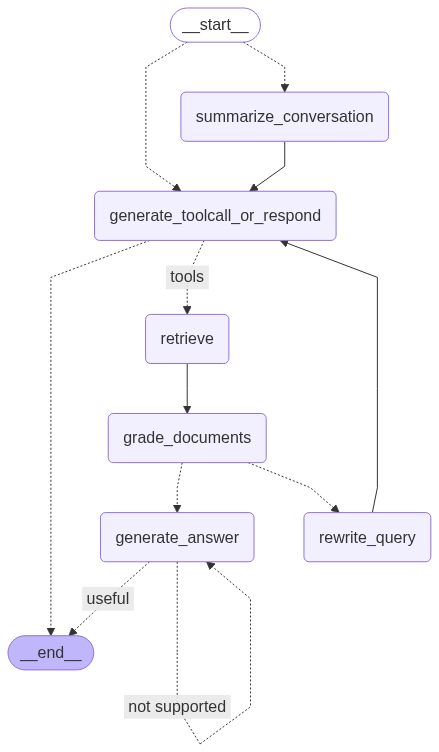

In [13]:
from IPython.display import Image, display
graph = graph_object.build_graph()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [193]:
user_input = "Hello!"
thread_id = str(uuid.uuid4())
policy_number = "AU1234"
message = [HumanMessage(content=user_input)]
config = {"configurable":{"thread_id":thread_id}}
response = graph.invoke({"messages":message,"policy_number":policy_number},config)
for m in response['messages']:
    m.pretty_print()

Inside generate_toolcall_or_respond
================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today? If you have any questions or need information, feel free to ask!


In [194]:
user_input = "Can you tell me about Homeowner insurance and whom should it purchase?"
thread_id = str(uuid.uuid4())
policy_number = "AU1234"
message = [HumanMessage(content=user_input)]
config = {"configurable":{"thread_id":thread_id}}
response = graph.invoke({"messages":message,"policy_number":policy_number},config)
for m in response['messages']:
    m.pretty_print()

Inside generate_toolcall_or_respond
================================ Human Message =================================

Can you tell me about Homeowner insurance and whom should it purchase?
================================== Ai Message ==================================

Homeowner's insurance is a form of property insurance that covers losses and damages to an individual's house and assets in the home. It also provides liability coverage against accidents in the home or on the property. 

Homeowner's insurance typically covers:

1. Damage to the interior or exterior of your house.
2. Loss or theft of belongings.
3. Personal liability for damage or injuries caused to third parties.
4. Coverage for additional living expenses if a temporary relocation is necessary.

It is generally purchased by homeowners to protect their property and possessions within the home. Lenders often require proof of homeowner's insurance before approving a mortgage. It's a wise purchase for any homeowner to safe

In [199]:
user_input = """ 
Yesterday, a tree has fallen on my house and damage the house and its some content.
let me know what has been covered and what not. Also, tell me how i can file a claim 
for the same.
"""
thread_id = str(uuid.uuid4())
policy_number = "AU1234"
message = [HumanMessage(content=user_input)]
config = {"configurable":{"thread_id":thread_id}}
response = graph.invoke({"messages":message,"policy_number":policy_number},config)
for m in response['messages']:
    m.pretty_print()

Inside generate_toolcall_or_respond
Dense embeddings are completed
Sparse Embeddings are completed
Search results are completed
Inside grade_documents
Message printing is completed
Going into filter documents
Inside decide_to_generate
Inside generate_answer
Inside decide_to_regenerate
================================ Human Message =================================

 
Yesterday, a tree has fallen on my house and damage the house and its some content.
let me know what has been covered and what not. Also, tell me how i can file a claim 
for the same.

================================== Ai Message ==================================
Tool Calls:
  hybrid_retriever (call_G7jjQi2g2rN2UMQ2Q2NIm27y)
 Call ID: call_G7jjQi2g2rN2UMQ2Q2NIm27y
  Args:
    query: tree fallen damage coverage and filing claim
    policy_number: AU1234
================================= Tool Message =================================
Name: hybrid_retriever

[{'id': '9bb40f1d-499e-46ca-94dc-a55de951ca27',
 'metadata': {'pol

In [200]:
user_input = """ 
can you tell me more on claim filing process. Is there any contact?
"""
message = [HumanMessage(content=user_input)]
response = graph.invoke({"messages":message,"policy_number":policy_number},config)
for m in response['messages']:
    m.pretty_print()

Inside generate_toolcall_or_respond
================================ Human Message =================================

 
Yesterday, a tree has fallen on my house and damage the house and its some content.
let me know what has been covered and what not. Also, tell me how i can file a claim 
for the same.

================================== Ai Message ==================================
Tool Calls:
  hybrid_retriever (call_G7jjQi2g2rN2UMQ2Q2NIm27y)
 Call ID: call_G7jjQi2g2rN2UMQ2Q2NIm27y
  Args:
    query: tree fallen damage coverage and filing claim
    policy_number: AU1234
================================= Tool Message =================================
Name: hybrid_retriever

[{'id': '9bb40f1d-499e-46ca-94dc-a55de951ca27',
 'metadata': {'policy_number': 'AU1234',
              'text': '# Home Insurance\n'
                      '\n'
                      '| 6. **Subsidence** or ground **heave** of the site on '
                      'which the **buildings** stand or **landslip**         

In [201]:
user_input = """ 
yes, please find more relevant contact details from my policy documents
"""
message = [HumanMessage(content=user_input)]
response = graph.invoke({"messages":message,"policy_number":policy_number},config)
for m in response['messages']:
    m.pretty_print()

Inside generate_toolcall_or_respond
Dense embeddings are completed
Sparse Embeddings are completed
Search results are completed
Inside grade_documents
Message printing is completed
Going into filter documents
Inside decide_to_generate
Inside generate_answer
Inside decide_to_regenerate
================================ Human Message =================================

 
Yesterday, a tree has fallen on my house and damage the house and its some content.
let me know what has been covered and what not. Also, tell me how i can file a claim 
for the same.

================================== Ai Message ==================================
Tool Calls:
  hybrid_retriever (call_G7jjQi2g2rN2UMQ2Q2NIm27y)
 Call ID: call_G7jjQi2g2rN2UMQ2Q2NIm27y
  Args:
    query: tree fallen damage coverage and filing claim
    policy_number: AU1234
================================= Tool Message =================================
Name: hybrid_retriever

[{'id': '9bb40f1d-499e-46ca-94dc-a55de951ca27',
 'metadata': {'pol

In [208]:
user_input = """ 
for point# 1, can you confirm from my policy document if damage falls under the 
covered categories?
"""
message = [HumanMessage(content=user_input)]
response = graph.invoke({"messages":message,"policy_number":policy_number},config)
for m in response['messages']:
    m.pretty_print()

Inside generate_toolcall_or_respond
Dense embeddings are completed
Sparse Embeddings are completed
Search results are completed
Inside grade_documents
Message printing is completed
Going into filter documents
Inside decide_to_generate
Inside generate_answer
Inside decide_to_regenerate
================================ Human Message =================================

 
for point# 1, can you confirm from my policy document if damage falls under the 
covered categories?

================================== Ai Message ==================================
Tool Calls:
  hybrid_retriever (call_Q4tzAJJvorpgdAKttL0H4JPa)
 Call ID: call_Q4tzAJJvorpgdAKttL0H4JPa
  Args:
    query: confirm if damage falls under covered categories
    policy_number: AU1234
================================= Tool Message =================================
Name: hybrid_retriever

[{'id': '32018025-11ea-4ec8-8af3-b74d6df1f5f7',
 'metadata': {'policy_number': 'AU1234',
              'text': '# General Exclusions\n'
         

In [14]:
user_input = """ 
Can you tell me how my home is covered if it got damage due to earthquake?
"""
thread_id = str(uuid.uuid4())
policy_number = "AU1234"
message = [HumanMessage(content=user_input)]
config = {"configurable":{"thread_id":thread_id}}
response = graph.invoke({"messages":message,"policy_number":policy_number},config)
for m in response['messages']:
    m.pretty_print()

Inside generate_toolcall_or_respond
Dense embeddings are completed
Sparse Embeddings are completed
Search results are completed
Inside grade_documents
================================ Human Message =================================

 
Can you tell me how my home is covered if it got damage due to earthquake?

================================== Ai Message ==================================
Tool Calls:
  hybrid_retriever (call_NNB0FQW4a3zV76RcDMvt38Uv)
 Call ID: call_NNB0FQW4a3zV76RcDMvt38Uv
  Args:
    query: earthquake coverage
    policy_number: AU1234
================================= Tool Message =================================
Name: hybrid_retriever

[{'id': '32018025-11ea-4ec8-8af3-b74d6df1f5f7',
 'metadata': {'policy_number': 'AU1234',
              'text': '# General Exclusions\n'
                      '\n'
                      'These exclusions apply throughout your policy.\n'
                      '\n'
                      'We will not pay for:\n'
                      '\n

KeyboardInterrupt: 